# Домашнее задание 1.
## Игорь Рухович. 22МАГИАД, 1 курс
### ВШЭ-НН 2023

В работе был использован датасет **Concrete Compressive Strength**
(https://archive-beta.ics.uci.edu/dataset/165/concrete+compressive+strength)

В данных содержится информация о прочности бетона на сжатие (МПа) в зависимости от его состава и возраста.


In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

np.set_printoptions(precision=4, suppress=True)

In [2]:
data_folder = "../data/"
concrete_path = "Concrete_Data.xls"

random_state = 12345
n_jobs = 8

In [3]:
df = pd.read_excel(data_folder + concrete_path)
df.head(10)

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.029847
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,365,43.698299
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.447770
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.854291
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,28,39.289790


## **1. Разведовательный анализ данных (EDA).**
### **1.1. Узнать больше про физический смысл параметров объектов.**
Из описания колонок видим, что мы имеем дело с 8 признаками о бетоне: 7 компонент его состава **на момент изготовления**, перечисленные в килограммах на кубометр смеси и возраст бетона в днях. Последний признак отражает максимальное давление, которое может выдержать такой бетон (то есть давление, при котором этот бетон ломается под прессом)

Для удобства использования переименуем колонки датасета более короткими названиями:

In [4]:
columns_orig = df.columns
df.columns = [f"comp_{i}" for i in range(1, 8)] + ["age", "strength"]
df

,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036


### **1.2. Посмотреть на типы.**
### **1.3. Наличие пропусков.**
### **1.4. Общий объем выборки.**
Видим из таблицы выше, что компоненты в килограммах указаны в дробном виде с точностью до 100 грамм, возраст представлен целым числом дней с момента заливки. Прочность же дана с большой точностью - судя по всему, это показания датчика на прессе. 

In [5]:
print(df.dtypes)
print(df.isna().any())
df.shape

comp_1      float64
comp_2      float64
comp_3      float64
comp_4      float64
comp_5      float64
comp_6      float64
comp_7      float64
age           int64
strength    float64
dtype: object
comp_1      False
comp_2      False
comp_3      False
comp_4      False
comp_5      False
comp_6      False
comp_7      False
age         False
strength    False
dtype: bool


(1030, 9)

Пропуски в данных отсутствуют. Общий объем - 1030 экспериментов.
### **1.5. Проанализировать признаки.**
#### **1.5.1. По составу.**
Соберём некоторые статистики: среднее, стандартное отклонение и каждый 25-й процентиль:

In [6]:
df.describe()

,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


Дополнительно построим гистограммы распределения для каждого признака и отдельно для целевой переменной, чтобы лучше понять их структуру и распределение:

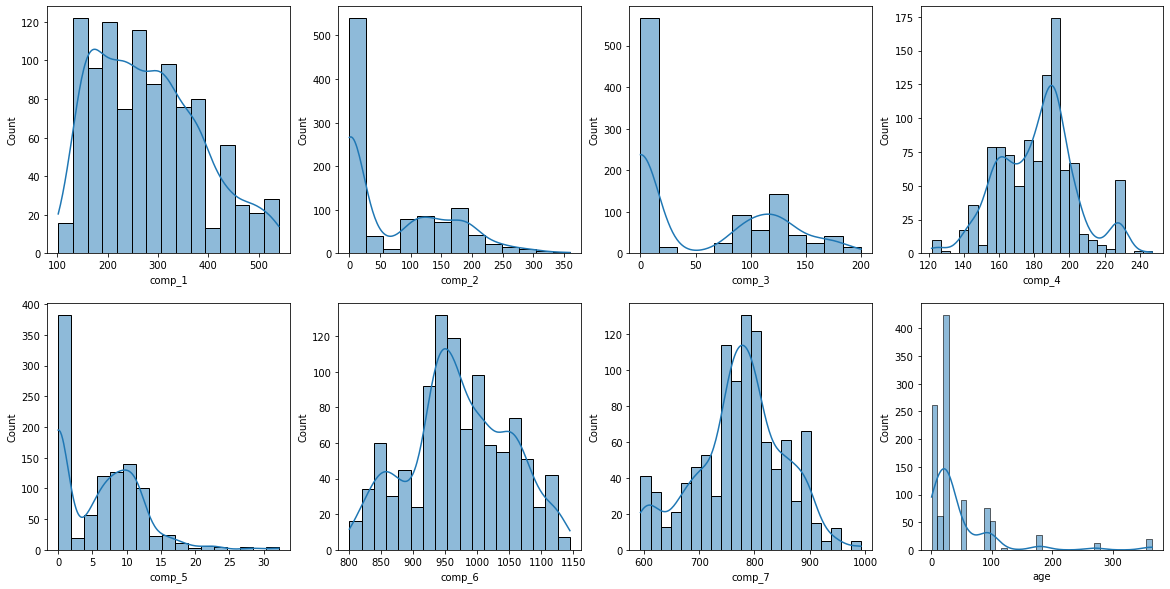

In [7]:
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(20,10)

for i in range(8):
    sns.histplot(data=df, x=df.columns[i], ax=np.ravel(axs)[i], kde=True)

<AxesSubplot:xlabel='strength', ylabel='Count'>

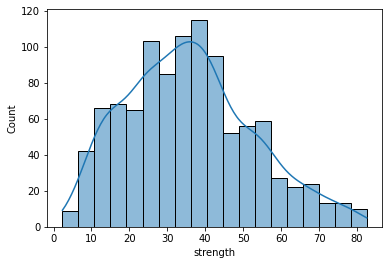

In [8]:
sns.histplot(data=df, x="strength", kde=True)

По гистограммам распределения тяжело определить какую-то структуру (что и ожидаемо, т. к. признаки выбирались исследователями экспериментально). Видим, что у 2, 3 и 5 компонента встречается много нулевых (или околонулевых) значений. Тут мы начинаем немного **больше понимать физический смысл** - основные компоненты бетона - цемент (№1), вода (№4) и наполнитель (в данных присутствует крупный №6 и мелкий №7 - видимо, щебенка и песок). Очевидно, что остальные компоненты - дополнительные, поэтому они присутствуют не везде и часто в небольшом количестве.

По возрасту видим, что большая часть экспериментов проводилась в первые дни после застывания, а дальше эксперименты проводились редко - это логично, ведь в теории со временем бетон застывает и его прочность перестает сильно меняться.

Гистограмма расперделения самой прочности мало о чем нам говорит - лишь можем найти моду в ~40МПа и понять, что прочность, вообще-то может сильно отличаться. Но самый прочный бетон, который удавалось сделать исследователям, крепче среднего всего в 2 раза.

#### **1.5.2. По отношению к целевой переменной (target-у).**

Для начала посмотрим на матрицу корреляции Пирсона всех признаков:

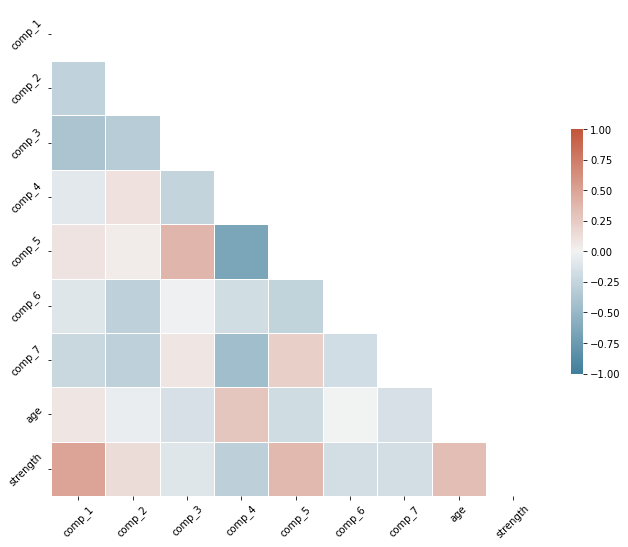

In [9]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool), 0)
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=45)
plt.yticks(rotation=45)
print()

Видим сильную корреляцию между 5 и 3, 5 и 4 признаками. Признак 5 - пластификатор, отрицательно коррелирует с содержанием воды _(**Пластификатор** — поверхностно-активная добавка, добавляемая в строительные растворы и бетонные смеси для облегчения укладки в форму и **снижения содержания воды** - Википедия)_ - логично.

Видим, что возраст смеси слабо коррелирует с каждой из составляющих - это хорошо тем, что подтверждает корректность эксперимента (если исследователи меняли возраст замера, то они не меняли состав, и, наоборот, с разным составом сравнивался одинаковый возраст). Напомню, что состав тут - это содержание компонентов **на момент заливки смеси,** а не в момент измерения прочности.

По целевой переменной - сразу бросается в глаза сильная положительная корреляция с первым компонентом (цемент), а также средняя с пластификатором и возрастом и отрицательная с водой:
 - вода делает бетон менее прочным
 - пластификатор убирает воду и увеличивает прочность
 - с течением времени бетон становится прочнее
 - основную прочность даёт количество цемента

Рассмотрим распределения целевой переменной в зависимости от каждого из признаков поодиночке:

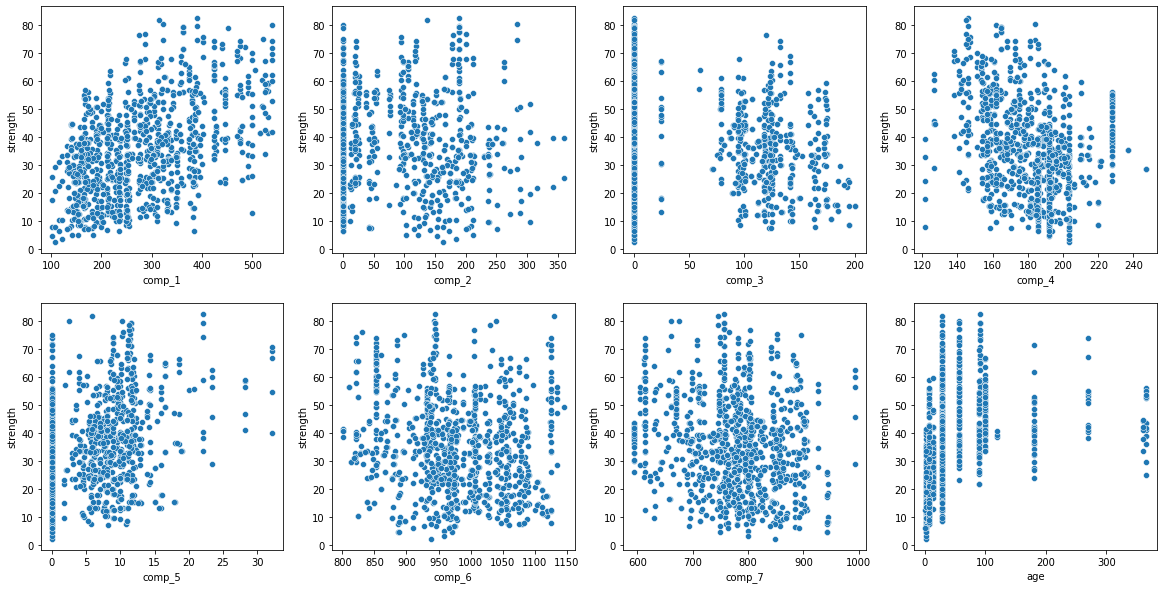

In [10]:
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(20,10)

for i in range(8):
    sns.scatterplot(data=df, x=df.columns[i], y="strength", ax=np.ravel(axs)[i])

Из уточнений, которые теперь видим:
 - Если добавляли компонент 3 (летучая зола), то клали в основном от 100кг, сам по себе компонент слабо влияет на прочность и, скорее, её уменьшает
 - Чем больше воды (4) - тем меньше в среднем прочность, но, до 150кг воды - наоборот (слишком сухая смесь?)
 - Пластификатор (5) в среднем делает бетон прочнее, но с увеличением количества разброс увеличивается - значит, для прочности нужно что-то ещё
 - Не ясно, как количество щебенки и песка (6 и 7) влияет на прочность само по себе
 - С возрастом прочность быстро растёт в течении первых 100 дней, затем рост замедляется, а через год прочность немного уменьшается

#### **1.5.3. По отношению друг к другу.**
Рассмотрим попарные распределения признаков. Цветом отметим прочность (чем темнее - тем прочнее):

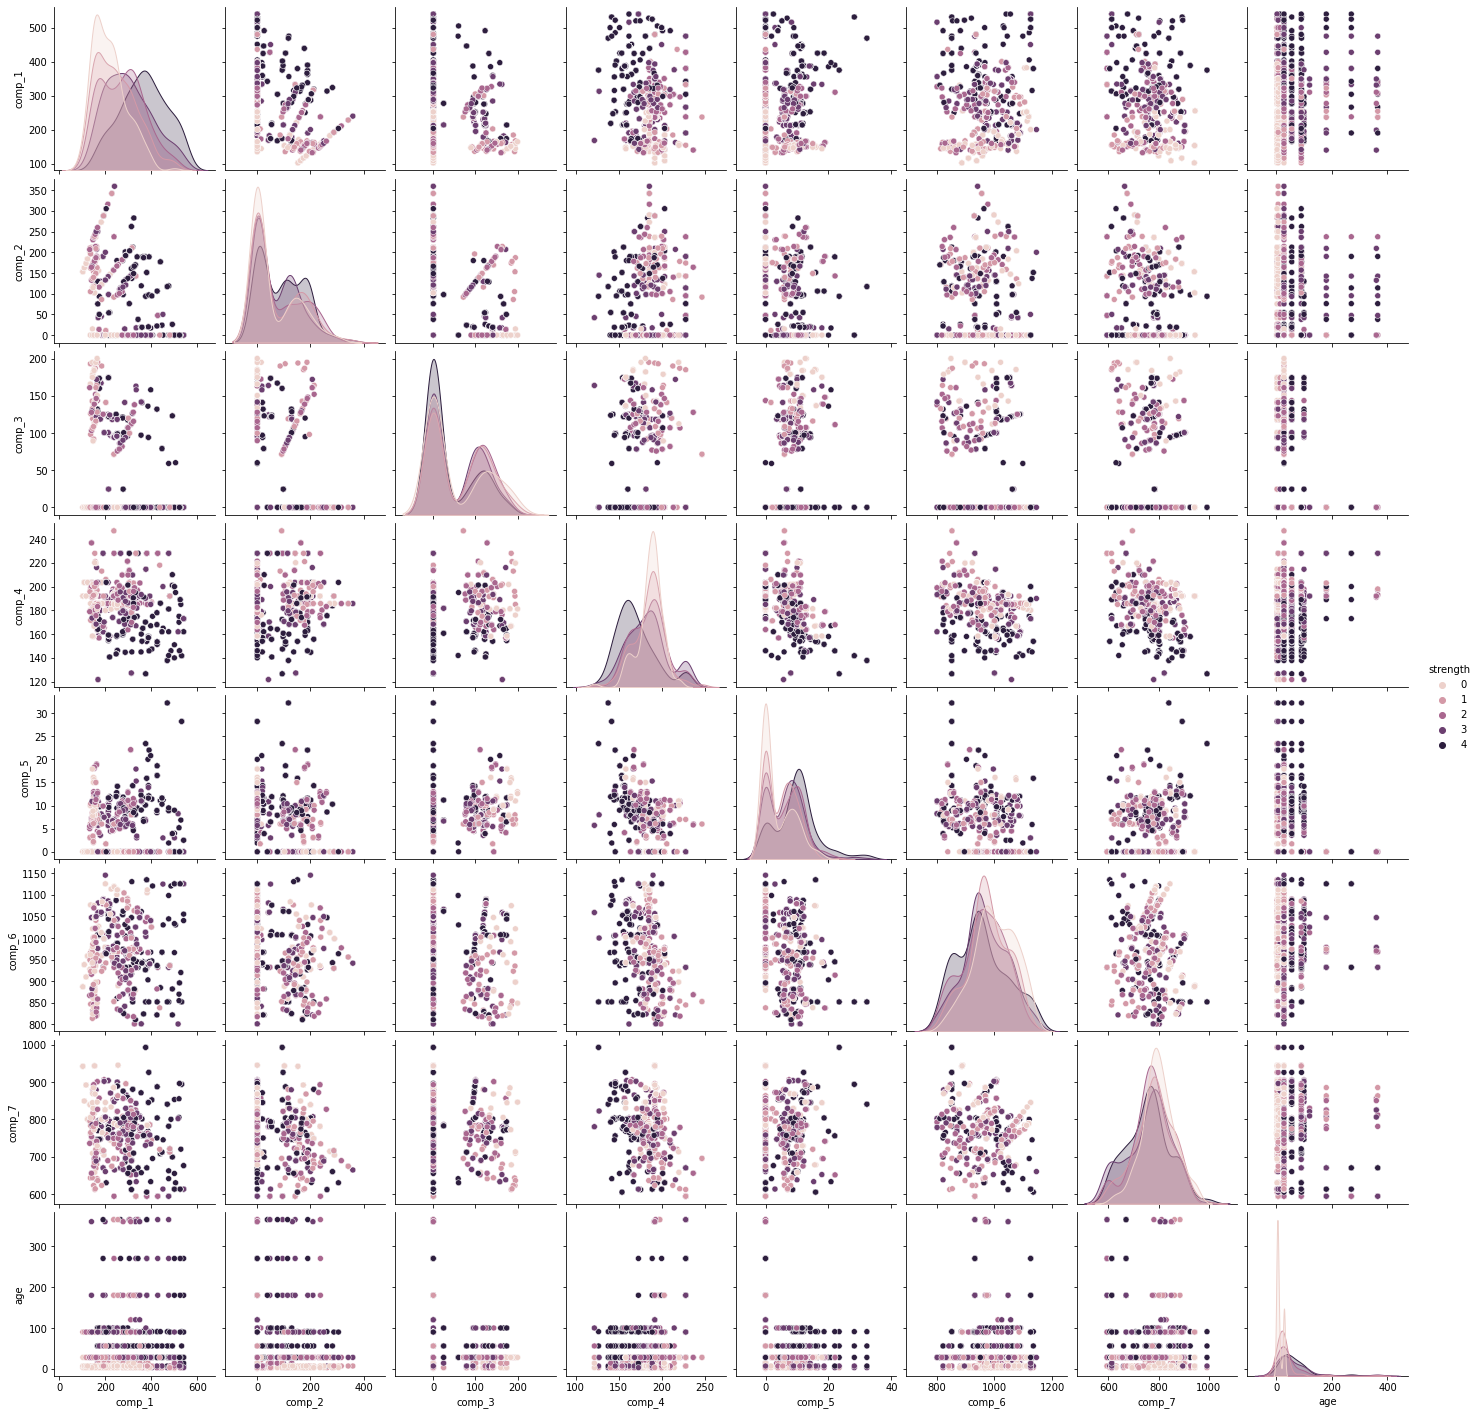

In [11]:
df_pp = df.copy()
df_pp["strength"] = pd.qcut(df["strength"], 5, labels=False)
sns.pairplot(df_pp, hue="strength")

В ячейках 1-2, 1-3, 2-3 видим линии - эти компоненты, судя по всему, часто клались в определённой пропорции. Причём линии темнеют к верхним концам - значит увеличение количества ингридиентов способствовало большей прочности. В целом, **все признаки были заданы экспериментаторами искусственно, а значит нет большого смысла смотреть их попарные зависимости**.

Точки с высоким значением целевой переменной внешне наиболее хорошо отделимы при использовании 1 или 4 признака (цемент и вода), а также возраста (со временем бетон крепчает)

### **1.6. Анализ выбросов.**
Поговорим про выбросы. В данном эксперименте все значения признаков заданы вручную людьми, поэтому с точки зрения природы данных выбросов тут быть не может. Единственные возможные выбросы - человеческие ошибки (ошибки при записи чисел, ошибки при обработке/транспортировке данных).

Человеческие ошибки отследить труднее, но мы можем сказать, что:
 - Нет значений меньше 0 - всё верно. Число дней >= 1, прочность >= 35МПа
 - Все гистограммы распределения признаков, а также гистограмма целевой переменной выглядят довольно гладко. Не похоже на наличие выбросов
 - В данных нет пропущенных/испорченных значений
 - Нет очень больших значений ни по одному признаку: максимум в килограммах не превышает 1145, в днях - 365, в МПа - 83

Исходя из небольшого предварительного анализа, сделаем предположение, что выбросов в данных нет и не будем проводить более глубокий анализ в этой области.

### **1.7. Другие статистики.**
Из гистограмм распределения каждого признака (и их физического смысла) можно заметить, что в данных нет автокорреляции (зависимости данных от самих себя со сдвигом). Данные не периодичные, не имеют временных меток сами по себе -> можем быть более-менее уверены в отсутствии автокорреляции.

Для проверки на мультиколлинеарность (линейную зависимость признаков) посмотрим на сингулярные числа матрицы признаков:

In [12]:
X_norm = StandardScaler().fit_transform(df.loc[:,:"age"])
u, s, vt = np.linalg.svd(X_norm, full_matrices=False)
s

array([48.4591, 38.1929, 37.1544, 32.3199, 31.3073, 28.5278, 13.53  ,
        5.5627])

Видим, что в целом все собственные числа матрицы довольно большие, а значит выраженной линейной зависимости в данных нет. В дальнейшем ещё вернёмся к SVD и попробуем понизить размерность признаков.

## **2. Рассмотреть две задачи: классификацию и регрессию.**
### **2.1. Сделать предположение о природе зависимости между target-ом и вашими данными.**
Из наших данных довольно понятным образом выстраивается задача регрессии: научиться предсказывать прочность бетона по его составу и времени с момента заливки. Это может пригодится для нахождения оптимального состава.

Задачу классификации можно поставить искусственно. Зададим желаемую прочность (например, прочнее, чем 90% других экспериментов) и будет тренировать модель классификации состава бетона на "хороший" и "плохой", если он выдерживает или не выдерживает данную нагрузку.

О зависимости target от данных признаков для начала предположим самое простое - зависимость линейная. Обучим самые простые модели - линейной регрессии и логистической регрессии.

Четко зададим данные:

In [13]:
X = df.loc[:,:"age"]
print(X.head(5), "\n")

y_reg = df["strength"]
print(y_reg.head(5), "\n")

q = df['strength'].quantile(0.9)
print(f"90th quantile of y is: {q:.3f}")
y_clf = pd.Series(df["strength"] > q, dtype=int)
print(y_clf.head(5), "\n")

   comp_1  comp_2  comp_3  comp_4  comp_5  comp_6  comp_7  age
0   540.0     0.0     0.0   162.0     2.5  1040.0   676.0   28
1   540.0     0.0     0.0   162.0     2.5  1055.0   676.0   28
2   332.5   142.5     0.0   228.0     0.0   932.0   594.0  270
3   332.5   142.5     0.0   228.0     0.0   932.0   594.0  365
4   198.6   132.4     0.0   192.0     0.0   978.4   825.5  360 

0    79.986111
1    61.887366
2    40.269535
3    41.052780
4    44.296075
Name: strength, dtype: float64 

90th quantile of y is: 58.819
0    1
1    1
2    0
3    0
4    0
Name: strength, dtype: int64 



Разделим на тренировочные и тестовые в соотношении 70/30:

In [14]:
test_size=0.3

X_train, X_test, y_reg_train, y_reg_test = train_test_split(X, y_reg, test_size=test_size,
                                                            random_state=random_state)
X_train, X_test, y_clf_train, y_clf_test = train_test_split(X, y_clf, test_size=test_size,
                                                            random_state=random_state)
print(X_train.shape, X_test.shape)
print(y_reg_train.shape, y_reg_test.shape)
print(y_clf_train.shape, y_clf_test.shape)

(721, 8) (309, 8)
(721,) (309,)
(721,) (309,)


Заранее определим функцию подсчета метрик, чтобы не дублировать код:

In [15]:
# Заведём переменную для сохранения всех метрик всех моделей
scores = {}

def compute_metrics(model, name, task, max_train_size=None, max_test_size=None):
    if task not in ["reg", "clf"]:
        raise RuntimeError(f"Wrong task: {task}")

    scores[name] = {}
    scores[name]["train"] = {}
    scores[name]["test"] = {}

    reg_metric_1 = lambda y_true, y_pred: mean_squared_error(y_true, y_pred,
                                                             squared=False)
    reg_metric_2 = lambda y_true, y_pred: r2_score(y_true, y_pred)
    clf_metric_1 = lambda y_true, y_pred: roc_auc_score(y_true, y_pred)
    clf_metric_2 = lambda y_true, y_pred: accuracy_score(y_true, y_pred)
    metrics = {"reg": [("RMSE", reg_metric_1), ("R2", reg_metric_2)],
               "clf": [("ROC AUC", clf_metric_1), ("Accuracy", clf_metric_2)]}
    y = {"reg": {"train": y_reg_train.values, "test": y_reg_test.values},
         "clf": {"train": y_clf_train.values, "test": y_clf_test.values},
         "pred": {"train": model.predict(X_train), "test": model.predict(X_test)}}
    y_size = {"train": y["reg"]["train"].shape[0] if max_train_size is None else max_train_size,
              "test": y["reg"]["test"].shape[0] if max_test_size is None else max_test_size}

    for metric in metrics[task]:
        for data_type in ["train", "test"]:
            scores[name][data_type][metric[0]] = metric[1](y[task][data_type][:y_size[data_type]],
                                                           y["pred"][data_type][:y_size[data_type]])
            print(f'Model {name} ({task}), {metric[0]} score on {data_type}:\t\t' +
                  f'{scores[name][data_type][metric[0]]:.5f}')


### **2.2. Обучить соответсвующую модель.**

Обучаем линейную регрессию. В качестве метрик регрессии будем использовать стандартные: среднеквадратическую ошибку (квадратный корень из неё, RMSE) и долю объяснённой дисперсии (R2 score):

In [16]:
reg_1 = LinearRegression()
reg_1.fit(X_train, y_reg_train)

LinearRegression()

In [17]:
compute_metrics(reg_1, "linear_regression_v1", "reg")

Model linear_regression_v1 (reg), RMSE score on train:		10.20668
Model linear_regression_v1 (reg), RMSE score on test:		10.84582
Model linear_regression_v1 (reg), R2 score on train:		0.62003
Model linear_regression_v1 (reg), R2 score on test:		0.59378


Возьмём данные метрики за бейзлайн и будем пробовать их улучшать. Метрики на тестировочной выборке немногим меньше метрик на тренировке, а значит сильного переобучения нет. Перейдём к логистической регрессии:

In [18]:
clf_1 = LogisticRegression(penalty=None, random_state=random_state,
                           solver="lbfgs", n_jobs=n_jobs)
clf_1.fit(X_train, y_clf_train)

LogisticRegression(n_jobs=8, penalty=None, random_state=12345)

В качестве метрик используем также общепринятые accuracy и roc_auc_score (Area Under ROC Curve):

In [19]:
compute_metrics(clf_1, "logistic_regression_v1", "clf")

Model logistic_regression_v1 (clf), ROC AUC score on train:		0.76935
Model logistic_regression_v1 (clf), ROC AUC score on test:		0.75033
Model logistic_regression_v1 (clf), Accuracy score on train:		0.94036
Model logistic_regression_v1 (clf), Accuracy score on test:		0.93528


Также возьмём это за бейзлайн. Заметим, что метрики на train и test примерно равны (модель не переобучилась)

### **2.7. Используйте регуляризатор, если в этом есть необходимость.**
Поскольку разница в метриках между train и test получилась очень небольшой, **смысла в регуляризации нет**. Тем не менее, попробуем подключить l2-регуляризатор, чтобы немного "усреднить" метрики:

In [20]:
clf_2 = LogisticRegression(penalty="l2", random_state=random_state,
                           solver="lbfgs", n_jobs=n_jobs, C=0.0025)
clf_2.fit(X_train, y_clf_train)

LogisticRegression(C=0.0025, n_jobs=8, random_state=12345)

In [21]:
compute_metrics(clf_2, "logistic_regression_v2", "clf")

Model logistic_regression_v2 (clf), ROC AUC score on train:		0.75584
Model logistic_regression_v2 (clf), ROC AUC score on test:		0.75033
Model logistic_regression_v2 (clf), Accuracy score on train:		0.93897
Model logistic_regression_v2 (clf), Accuracy score on test:		0.93528


Перебрав (руками) разные значения параметра регуляризации С видим, что никакого смысла от этого нет. Метрика на test никуда расти не собирается)

#### **2.2.1. Переобучить, сравнить с "нормально" обученной.**
Хорошо заметить переобучение можно на классификации. Переобучение - это когда модель очень хорошо научилась работать с данными на тренировке, но имеет плохую обобщающую способность, поэтому не может сделать ничего полезного с новыми данными. Переобучение, помимо прочего, часто происходит, когда на тренировку мы подаём слишком мало данных, и эти данные плохо описывают реальную ситуацию, что можно увидеть на тестовой выборке.

Попробуем передать в модель результаты только 50 экспериментов (из ~700, как это делали ранее):

In [22]:
train_size = 50

clf_2 = LogisticRegression(penalty=None, random_state=random_state,
                           solver="lbfgs", n_jobs=n_jobs)
clf_2.fit(X_train.iloc[:train_size], y_clf_train.iloc[:train_size])

LogisticRegression(n_jobs=8, penalty=None, random_state=12345)

In [23]:
compute_metrics(clf_2, "logistic_regression_v2", "clf", max_train_size=train_size)

Model logistic_regression_v2 (clf), ROC AUC score on train:		1.00000
Model logistic_regression_v2 (clf), ROC AUC score on test:		0.61215
Model logistic_regression_v2 (clf), Accuracy score on train:		1.00000
Model logistic_regression_v2 (clf), Accuracy score on test:		0.90291


Действительно, видим, что на 50 объектах логистическая регрессия научилась работать идеально - абсолютная точность, все метки классов предсказаны верно. При этом ROC AUC на тестовой выборке говорит о том, что наша модель немногим лучше случайного выбора меток классов.

Высокая точность (accuracy) на test тут говорит о том, что в тестовой выборке, вообще то, высокий дисбаланс классов (помним, что мы классифицируем как "1" те смеси, которые лучше 90% других экспериментов, то есть, в среднем, 1/10 выборки; Заметим, что если модель будет всегда выдавать в ответе 0, её accuracy будет 90%). Поэтому accuracy = 0.9 - плохое значение в данном эксперименте.

#### **2.2.2. Недообучить, сравнить с "нормально" обученной.**

По аналогии попробуем недообучить классификацию - подадим столько же элементов на тренировку (50), а предсказывать будем на полных данных:

**На самом деле это игра слов:**
 - Мы **переобучили** модель на 50 строчках (под эти 50 строчек)
 - В то же время мы **недообучили** модель, подав ей только 50 строчек (но посчитав, что она натренирована, будем смотреть на метрики train)

In [24]:
train_size = 50

clf_3 = LogisticRegression(penalty=None, random_state=random_state,
                           solver="lbfgs", n_jobs=n_jobs)
clf_3.fit(X_train.iloc[:train_size], y_clf_train.iloc[:train_size])

LogisticRegression(n_jobs=8, penalty=None, random_state=12345)

In [25]:
compute_metrics(clf_3, "logistic_regression_v3", "clf")

Model logistic_regression_v3 (clf), ROC AUC score on train:		0.67058
Model logistic_regression_v3 (clf), ROC AUC score on test:		0.61215
Model logistic_regression_v3 (clf), Accuracy score on train:		0.90014
Model logistic_regression_v3 (clf), Accuracy score on test:		0.90291


Видим, что и ожидалось: на любом наборе данных модель показывает плохой результат.

Переобучение и недообучение можно также наблюдать на итеративных алгоритмах: слишком мало итераций - недообучили, слишком много - переобучили.

####  **2.3.1. Провести тесты на значимость коэффициентов регрессии.**
####  **2.3.2. Тест на значимость регрессии.**

Насколько я понял, это один и тот же тест - F-тест (тест Фишера) проверки значимости (коэффициентов) регрессии. По сути, тест, который говорит, насколько значимо отличие коэффициентов от 0. Я воспользовался реализацией для модели из scikit-learn со stackoverflow, которая повторяет результат работы библиотеки statmodels.

In [26]:
######### Далее плохой код, можно не читать, я почти не менял :)

def regression_test(model, X, y):
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    params = np.append(model.intercept_,model.coef_)
    predictions = model.predict(X)

    newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params / sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)

    return pd.DataFrame({"Coefficients": params, "Standard Errors": sd_b,
                         "t values": ts_b, "Probabilities": p_values})

In [27]:
regression_test(reg_1, X_test, y_reg_test)

,Coefficients,Standard Errors,t values,Probabilities
0,-39.9833,54.788,-0.730,0.466
1,0.1312,0.016,8.036,0.000
2,0.1066,0.020,5.309,0.000
3,0.0995,0.024,4.177,0.000
4,-0.1168,0.085,-1.375,0.170
5,0.2589,0.201,1.291,0.198
6,0.0233,0.020,1.187,0.236
7,0.0224,0.022,1.035,0.301
8,0.1157,0.010,11.714,0.000


Смотрим на колонку Probabilities:
 - Первая строчка отвечает за сдвиг, остальные - коэффициенты признаков
 - Видим, что в нашей модели признаки 1, 2, 3 и 8 (цемент, 2 присадки и возраст) с вероятностью меньше, чем 0.01% необходимы для построения регрессии - интересный вывод, учитывая, что мы считали цемент и возраст одними из главных составляющих

### **2.4. Попробовать настроить гиперпараметры модели.**
### **2.5. Выбрать еще минимум две модели, обучить, сравнить результаты.**

Попробуем ещё 2 модели: дерево решений и градиентный бустинг над лесом:

In [28]:
reg_2 = DecisionTreeRegressor(criterion="friedman_mse", splitter="best",
                              random_state=random_state)
reg_2.fit(X_train, y_reg_train)

DecisionTreeRegressor(criterion='friedman_mse', random_state=12345)

In [29]:
compute_metrics(reg_2, "decision_tree_v1", "reg")

Model decision_tree_v1 (reg), RMSE score on train:		0.18134
Model decision_tree_v1 (reg), RMSE score on test:		7.17646
Model decision_tree_v1 (reg), R2 score on train:		0.99988
Model decision_tree_v1 (reg), R2 score on test:		0.82215


Видим, что без дополнительных параметров модель сильно переобучилась - стандартное явление для всех древесных алгоритмов. Тем не менее, RMSE и R2 на test тут сильно лучше, чем в модели линейной регрессии. Ограничим максимальное число листовых нод и посмотрим на результат:

In [30]:
reg_3 = DecisionTreeRegressor(criterion="friedman_mse", splitter="best",
                              random_state=random_state, max_leaf_nodes=32)
reg_3.fit(X_train, y_reg_train)

DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=32,
                      random_state=12345)

In [31]:
compute_metrics(reg_3, "decision_tree_v2", "reg")

Model decision_tree_v2 (reg), RMSE score on train:		6.18057
Model decision_tree_v2 (reg), RMSE score on test:		7.79541
Model decision_tree_v2 (reg), R2 score on train:		0.86067
Model decision_tree_v2 (reg), R2 score on test:		0.79015


Так уже намного лучше. Приведу для сравнения метрики из линейной регрессии:

In [32]:
scores["linear_regression_v1"]

{'train': {'RMSE': 10.206684593367575, 'R2': 0.6200304546844051},
 'test': {'RMSE': 10.845820012365117, 'R2': 0.5937830197399014}}

Попробуем ещё более сложную модель - градиентный бустинг. Я не стал пробовать random forest из sklearn, так как это довольно промежуточное решение - слишком много случайности и возможностей переобучиться.

Из бустингов мне больше всех нравится XGBoost - самая быстрая реализация (не считая Intel OneDAL GBDT). Также в ней, в отличие от Intel, можно настраивать очень много параметров, и сама модель неплохо работает "из коробки".

In [33]:
reg_4 = XGBRegressor(tree_method="hist", objective="reg:squarederror",
                     eval_metric="rmse", seed=random_state)
reg_4.fit(X_train, y_reg_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [34]:
compute_metrics(reg_4, "gbdt_v1", "reg")

Model gbdt_v1 (reg), RMSE score on train:		0.50760
Model gbdt_v1 (reg), RMSE score on test:		5.18880
Model gbdt_v1 (reg), R2 score on train:		0.99906
Model gbdt_v1 (reg), R2 score on test:		0.90702


Простой вызов модели без дополнительных параметров сразу показал улучшение на 30% относительно решающего дерева, хотя и видим серьезное переобучение под train. Попробуем настроить параметры:

In [35]:
reg_5 = XGBRegressor(tree_method="hist", objective="reg:squarederror",
                     eval_metric="rmse", seed=random_state,
                     min_child_weight=15, min_split_loss=0.4, max_leaves=20)
reg_5.fit(X_train, y_reg_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=20,
             min_child_weight=15, min_split_loss=0.4, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [36]:
compute_metrics(reg_5, "gbdt_v2", "reg")

Model gbdt_v2 (reg), RMSE score on train:		1.64428
Model gbdt_v2 (reg), RMSE score on test:		4.08248
Model gbdt_v2 (reg), R2 score on train:		0.99014
Model gbdt_v2 (reg), R2 score on test:		0.94245


In [37]:
print(f"Число деревьев в последней модели: {reg_5.n_estimators}")

Число деревьев в последней модели: 100


Перебором параметров (вручную) удалось ещё заметно улучшить метрики. В итоге имеем:

In [38]:
print(f'Было:\t\t{scores["linear_regression_v1"]}')
print(f'Потом стало:\t{scores["decision_tree_v2"]}')
print(f'И в конце:\t{scores["gbdt_v2"]}')

Было:		{'train': {'RMSE': 10.206684593367575, 'R2': 0.6200304546844051}, 'test': {'RMSE': 10.845820012365117, 'R2': 0.5937830197399014}}
Потом стало:	{'train': {'RMSE': 6.180574267119943, 'R2': 0.8606724311642613}, 'test': {'RMSE': 7.795412158063226, 'R2': 0.7901488026165111}}
И в конце:	{'train': {'RMSE': 1.6442751254673384, 'R2': 0.9901388316301858}, 'test': {'RMSE': 4.082475256643841, 'R2': 0.942445350983646}}


Также посмотрим, как алгоритм оценил важность признаков (процент решений, принятых по этому признаку):

In [39]:
pd.Series(reg_5.feature_importances_, index=columns_orig.values[:-1])

Cement (component 1)(kg in a m^3 mixture)                0.317255
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    0.103584
Fly Ash (component 3)(kg in a m^3 mixture)               0.018579
Water  (component 4)(kg in a m^3 mixture)                0.078727
Superplasticizer (component 5)(kg in a m^3 mixture)      0.056407
Coarse Aggregate  (component 6)(kg in a m^3 mixture)     0.017914
Fine Aggregate (component 7)(kg in a m^3 mixture)        0.026494
Age (day)                                                0.381041
dtype: float32

В отличие от линейной регрессии, модель бустинга считает самыми важными признаками количество цемента, возраст и доменный шлак, при этом модель не видит принципиальной зависимости крепости бетона от количества щебенки и песка.

## **3. Возможно ли применить Feature Engineering для обогащения модели? Провести эксперименты.**
Из, возможно, недостающих признаков сразу приходит на ум **суммарная масса**. Суммарная масса компонентов, по сути, эквивалентна плотности бетона (т. к. общий объем всегда 1м^3). Попробуем добавить этот признак и сравнить результаты:

In [40]:
X_train.loc[:,"comp_1":"comp_7"].sum(axis=1)

688    2261.40
580    2371.90
866    2327.00
31     2210.00
454    2348.96
        ...   
769    2326.00
546    2298.80
382    2420.00
129    2428.60
482    2401.64
Length: 721, dtype: float64

In [41]:
X_train["density"] = X_train.loc[:,"comp_1":"comp_7"].sum(axis=1)
X_test["density"] = X_test.loc[:,"comp_1":"comp_7"].sum(axis=1)
X_train

,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,age,density
688,108.3,162.4,0.00,203.50,0.00,938.2,849.0,3,2261.40
580,290.2,193.5,0.00,185.70,0.00,998.2,704.3,7,2371.90
866,160.0,250.0,0.00,168.00,12.00,1049.0,688.0,28,2327.00
31,266.0,114.0,0.00,228.00,0.00,932.0,670.0,365,2210.00
454,250.0,0.0,95.69,191.84,5.33,948.9,857.2,56,2348.96
...,...,...,...,...,...,...,...,...,...
769,331.0,0.0,0.00,192.00,0.00,978.0,825.0,360,2326.00
546,333.0,0.0,0.00,192.00,0.00,931.2,842.6,28,2298.80
382,505.0,0.0,60.00,195.00,0.00,1030.0,630.0,28,2420.00
129,362.6,189.0,0.00,164.90,11.60,944.7,755.8,28,2428.60


In [42]:
reg_6 = XGBRegressor(tree_method="hist", objective="reg:squarederror",
                     eval_metric="rmse", seed=random_state,
                     min_child_weight=25, min_split_loss=0.4, max_leaves=20)
reg_6.fit(X_train, y_reg_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=20,
             min_child_weight=25, min_split_loss=0.4, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [43]:
compute_metrics(reg_6, "gbdt_v3", "reg")

Model gbdt_v3 (reg), RMSE score on train:		1.84517
Model gbdt_v3 (reg), RMSE score on test:		3.87720
Model gbdt_v3 (reg), R2 score on train:		0.98758
Model gbdt_v3 (reg), R2 score on test:		0.94809


In [44]:
reg_6.feature_importances_

array([0.1753, 0.0774, 0.0182, 0.0365, 0.0529, 0.0231, 0.0303, 0.3869,
       0.1994], dtype=float32)

Добавив новый признак и немного подкрутив параметр `min_child_weight`, получилось добиться ещё большей точности на test. Ура!

Видим, что вклад нового признака составляет в деревьях целых 20%!

### **2.6. Feature Selection.**
## **4. Попробовать PCA / SVD для сокращения размерности данных. Как это повлияет на процесс обучения и на резульат?**

Вернёмся к сингулярному разложению матрицы признаков и попробуем избавиться от некоторых из них, а затем заново обучим градиентный бустинг.

Предположение: градиентный бустинг умеет самостоятельно неявно отбирать признаки, поэтому подсунув ему результат PCA получим такие же значения метрик. Проверяем:

In [45]:
X = df.loc[:,:"age"]
X["density"] = X.loc[:,"comp_1":"comp_7"].sum(axis=1)
X_norm = StandardScaler().fit_transform(X)
u, s, vt = np.linalg.svd(X_norm, full_matrices=False)
s

array([52.5081, 41.4255, 38.0596, 33.9011, 31.3424, 29.0223, 15.6171,
       11.4224,  0.    ])

С точки зрения SVD, признак `density` является линейной комбинацией других и фактически бесполезен, поэтому последнее сингулярное число - 0 (хотя мы видим, что для бустинга признак имеет пользу). Найдём относительную погрешность аппроксимации в норме Фробениуса, которую мы получим, если заменим матрицу признаков другой, меньшей размерности:

In [46]:
tmp_s = np.append(s, 0)
tmp_s_sq = tmp_s**2
abs_errors_f = tmp_s_sq[::-1].cumsum()[::-1][1:]
errors = (abs_errors_f/tmp_s_sq.sum()*100).round(4)
print(f"Относительная погрешность аппроксимации в норме Фробениуса (число признаков -> % погрешности):")
pd.Series(errors, index=np.arange(1, 10))

Относительная погрешность аппроксимации в норме Фробениуса (число признаков -> % погрешности):


1    70.2578
2    51.7457
3    36.1197
4    23.7218
5    13.1247
6     4.0385
7     1.4075
8     0.0000
9     0.0000
dtype: float64

Видим, что если возьмём 6 признаков из 9, то получим всего 4% погрешности от исходной матрицы. Попробуем обучиться на этих данных:

In [47]:
new_rank = 6
X = u[:,:new_rank] @ np.diag(s[:new_rank])
X

array([[-0.7075,  3.151 ,  0.3162,  0.0081, -0.6804,  0.9038],
       [-0.8296,  3.2962,  0.4244, -0.1323, -0.6842,  0.8474],
       [ 4.4322,  1.0039, -0.4781,  1.1709, -1.4561, -2.0052],
       ...,
       [ 0.8783, -2.141 , -0.5089, -0.0685, -0.0891,  0.1085],
       [ 0.0534, -0.8238, -0.9679, -1.2636,  0.4779, -0.6474],
       [ 0.8855, -1.2645, -0.9696,  0.7212, -0.3587,  0.5989]])

In [48]:
X_train, X_test, y_reg_train, y_reg_test = train_test_split(X, y_reg, test_size=test_size,
                                                            random_state=random_state)

In [49]:
reg_7 = XGBRegressor(tree_method="hist", objective="reg:squarederror",
                     eval_metric="rmse", seed=random_state,
                     min_child_weight=10, min_split_loss=0.75, max_leaves=10)
reg_7.fit(X_train, y_reg_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=10,
             min_child_weight=10, min_split_loss=0.75, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [50]:
compute_metrics(reg_7, "gbdt_v4", "reg")

Model gbdt_v4 (reg), RMSE score on train:		2.70007
Model gbdt_v4 (reg), RMSE score on test:		7.05192
Model gbdt_v4 (reg), R2 score on train:		0.97341
Model gbdt_v4 (reg), R2 score on test:		0.82827


Почему-то прироста не случилось. Это можно объяснить, например, тем, что в датасете в целом немного признаков и не было нужды сокращать их количество. Видимо, таким образом мы выкинули полезную информацию.

## **5. Объединить результаты нескольких моделей. Подумайте, как это можно сделать. Провести эксперименты.**
Объединять результаты имеющихся моделей, кажется, нет смысла. Использованы 3 принципиально разных по сложности алгоритма (по метрикам видим, насколько каждый новый подход лучше предыдущего). При использовании таких моделей смысла от их объединения не должно быть.

Итоговые метрики:

In [51]:
for model in scores:
    print(f"Модель {model},\tрезультат:\t{scores[model]}")

Модель linear_regression_v1,	результат:	{'train': {'RMSE': 10.206684593367575, 'R2': 0.6200304546844051}, 'test': {'RMSE': 10.845820012365117, 'R2': 0.5937830197399014}}
Модель logistic_regression_v1,	результат:	{'train': {'ROC AUC': 0.7693548387096775, 'Accuracy': 0.9403606102635229}, 'test': {'ROC AUC': 0.7503293807641633, 'Accuracy': 0.9352750809061489}}
Модель logistic_regression_v2,	результат:	{'train': {'ROC AUC': 1.0, 'Accuracy': 1.0}, 'test': {'ROC AUC': 0.6121541501976285, 'Accuracy': 0.9029126213592233}}
Модель logistic_regression_v3,	результат:	{'train': {'ROC AUC': 0.6705837173579109, 'Accuracy': 0.9001386962552012}, 'test': {'ROC AUC': 0.6121541501976285, 'Accuracy': 0.9029126213592233}}
Модель decision_tree_v1,	результат:	{'train': {'RMSE': 0.18133806670661196, 'R2': 0.9998800618452587}, 'test': {'RMSE': 7.176457470755957, 'R2': 0.8221501438158801}}
Модель decision_tree_v2,	результат:	{'train': {'RMSE': 6.180574267119943, 'R2': 0.8606724311642613}, 'test': {'RMSE': 7.7954